In [8]:
import psycopg2 as ppg
import pandas as pd
import numpy as np
import random
import datetime
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [20]:
con = ppg.connect(dbname="tweets", user="patrick")

In [3]:
con.rollback()
with con.cursor() as cur:
    cur.execute("select user_id, max(tweets.created_at) as tweet_time, "
                "usr.created_at, last_tweet_at, (last_tweet_at < '2015-05-15') as churn, "
                "usr.followers_count, usr.friends_count from tweets inner join "
                "(select user_id, name, followers_count, friends_count, last_tweet_at, created_at from users "
                "where last_tweet_at is not null) as usr using (user_id) "
                "where tweets.created_at < '2015-04-04' group by user_id, usr.created_at, "
                "usr.last_tweet_at, usr.followers_count, usr.friends_count order by usr.created_at;")
    churn_df = pd.DataFrame(cur.fetchall(), columns=[c[0] for c in cur.description])

(201809, 8)


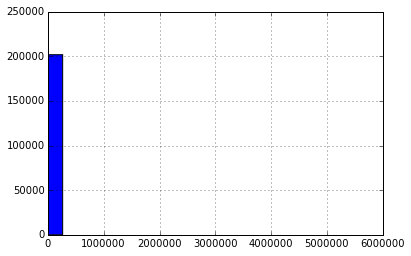

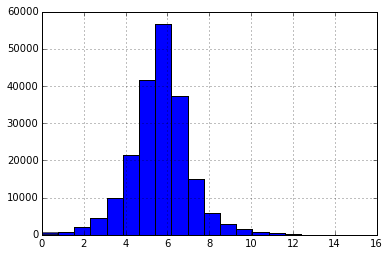

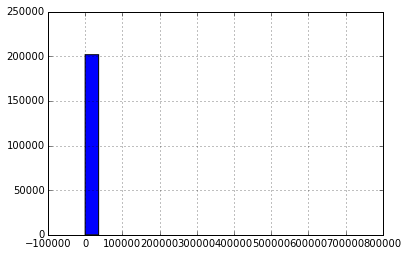

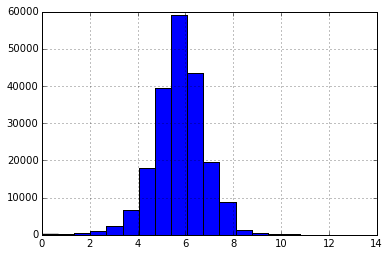

In [13]:
churn_df.columns
print churn_df.shape
churn_df.followers_count.hist(bins=20)
plt.figure(2)
churn_df.followers_count.map(np.log).replace([np.inf, -np.inf], np.nan).dropna().hist(bins=20)
plt.figure(3)
churn_df.friends_count.hist(bins=20)
plt.figure(4)
churn_df.friends_count.map(np.log).replace([np.inf, -np.inf], np.nan).dropna().hist(bins=20)

In [ ]:
# plot 
# training-testing
query_date = pd.to_datetime(datetime.datetime.strptime("2015-06-17", "%Y-%m-%d"))
churn_df['user_age'] = (query_date - churn_df.created_at).astype(np.int64)
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

training, testing = train_test_split(churn_df[['churn','followers_count','friends_count','user_age']], 
                                     train_size=0.8)

dscl = StandardScaler()
training_predictors = dscl.fit_transform(training.iloc[:,1:])
testing_predictors = dscl.transform(testing.iloc[:,1:])

In [31]:
import pickle
pickle.dump(dscl, file("scaler.pickle", "w"))

In [6]:
# model

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.externals import joblib
import sklearn



def try_model(training_predictors, training_response, testing_predictors, testing_response, the_model):
    the_model.fit(training_predictors, training_response)
    classfn = the_model.predict(testing_predictors)
    print "Number correct: ", (classfn==testing_response).sum()
    print "Baseline (training): ",  np.sum(training_response==True) / float(len(training_response))
    print "Percent correct (training): ", (the_model.predict(training_predictors)==
                                           training_response).sum() / float(len(training_response))
    print "Percent correct (testing): ", (classfn==testing_response).sum() / float(len(classfn))
    
    print sklearn.metrics.confusion_matrix(testing_response.astype(int), classfn.astype(int))
    print "Precision: ", sklearn.metrics.precision_score(testing_response.astype(int), classfn.astype(int))
    print "Recall: ", sklearn.metrics.recall_score(testing_response.astype(int), classfn.astype(int))
    
    return the_model


#clf.fit(training_predictors, training[:,0])
#clf
for cval in (100000,):
    print("C =", cval)
    sample_rows = range(0,training_predictors.shape[0])
    svm = try_model(training_predictors[sample_rows,:], training.iloc[sample_rows,0],
                    testing_predictors, testing.iloc[:,0], SVC(C=cval,class_weight='auto'))
    #joblib.dump(svm, 'svm_{}.pkl'.format(int(time.time())))
    pickle.dump(svm,file("svm{}.pkl".format(int(time.time())), "w"))
    

('C =', 100000)
Number correct:  25323
Baseline (training):  0.0950714475958
Percent correct (training):  0.628014147058
Percent correct (testing):  0.627397056637
[[23045 13515]
 [ 1524  2278]]
Precision:  0.144241119483
Recall:  0.599158337717


In [ ]:
def add_predictions_to_db():
    with con.cursor() as cur:
        for i, u in churn_df.iterrows():
            cur.execute("UPDATE users SET prediction = '{}' WHERE user_id = '{}'".format(
                svm.predict(dscl.transform(u[['followers_count', 'friends_count', 'user_age']]))[0], u.user_id))
            con.commit()
            
con.rollback()
add_predictions_to_db()